<a href="https://colab.research.google.com/github/shobhittya/deeplearning/blob/main/NewGAN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:

import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import cv2


from tqdm.notebook import tqdm_notebook as tqdm

import os


In [15]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/ciplab/real-and-fake-face-detection'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


  2%|▏         | 7.00M/431M [00:00<00:06, 72.3MB/s]

100%|██████████| 431M/431M [00:03<00:00, 144MB/s]


In [16]:
import os

DATA_DIR = './real-and-fake-face-detection'
print(os.listdir(DATA_DIR))

['real_and_fake_face_detection', 'real_and_fake_face']


In [49]:
real = "./real-and-fake-face-detection/real_and_fake_face/training_fake/"
fake = "./real-and-fake-face-detection/real_and_fake_face/training_real/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

**VISUALIZING THE REAL AND FAKE FACES**

In [51]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
#     print(labels)
    return image[...,::-1]

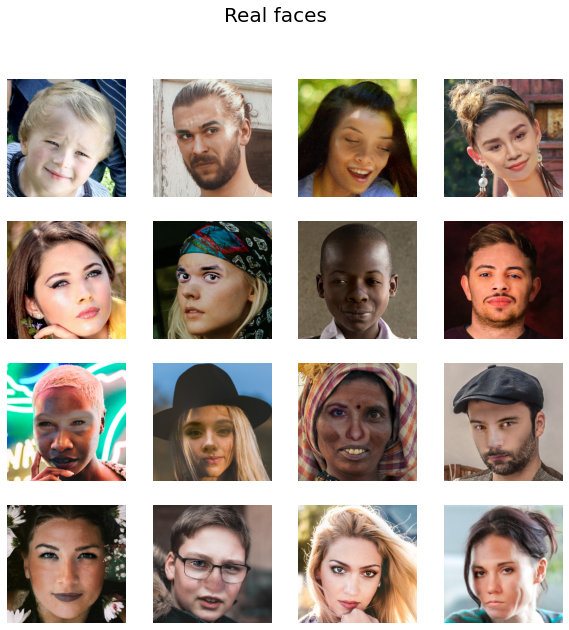

In [54]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

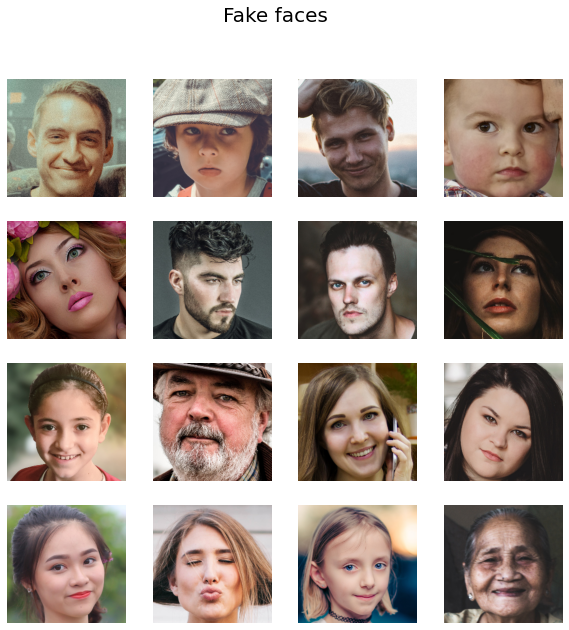

In [55]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fake faces",fontsize=20)
    plt.axis('off')

plt.show()

In [57]:
dataset_path = "./real-and-fake-face-detection/real_and_fake_face"


**DATA AUGMENTATION**

In [58]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.2)

In [59]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")

Found 1633 images belonging to 2 classes.


In [60]:
val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 408 images belonging to 2 classes.


**MOBILENET v2**

In [61]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(96,96,3))

9412608/9406464 [==============================] - 0s 0us/step


In [63]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

**CALLBACKS**

In [65]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [66]:
hist = model.fit_generator(train,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
52/52 [==============================] - 56s 410ms/step - loss: 0.9994 - accuracy: 0.5639 - val_loss: 0.8270 - val_accuracy: 0.5294
Epoch 2/20
52/52 [==============================] - 20s 388ms/step - loss: 0.5706 - accuracy: 0.7129 - val_loss: 1.1982 - val_accuracy: 0.4730
Epoch 3/20
52/52 [==============================] - 20s 385ms/step - loss: 0.4680 - accuracy: 0.7678 - val_loss: 1.0586 - val_accuracy: 0.5539
Epoch 4/20
52/52 [==============================] - 20s 388ms/step - loss: 0.3670 - accuracy: 0.8425 - val_loss: 0.9942 - val_accuracy: 0.5245
Epoch 5/20
52/52 [==============================] - 20s 388ms/step - loss: 0.3274 - accuracy: 0.8641 - val_loss: 0.9807 - val_accuracy: 0.5245
Epoch 6/20
52/52 [==============================] - 20s 386ms/step - loss: 0.3387 - accuracy: 0.8475 - val_loss: 0.9992 - val_accuracy: 0.5098
Epoch 7/20
52/52 [==============================] - 20s 387ms/step - loss: 0.3012 - accuracy: 0.8846 - val_loss: 1.0139 - val_accuracy: 0.5000

**VISUALIZING THE ACCURACY AND LOSS**

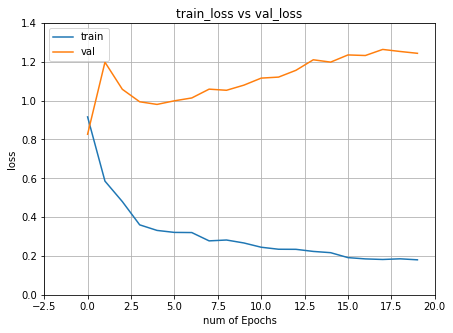

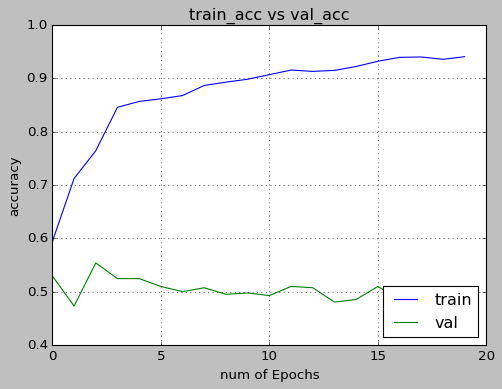

In [67]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

**VGG16 MODEL**

In [68]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="training")

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [69]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

58892288/58889256 [==============================] - 1s 0us/step


In [70]:
vgg16_model.output[-1]

<KerasTensor: shape=(7, 7, 512) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [74]:
# model = Sequential()
# for layer in vgg16_model.layers[:-1]:
#     model.add(layer)

# for layer in model.layers:
#     layer.trainable = False
    
# model.add(Dense(2, activation='softmax'))


model = Sequential([vgg16_model,
                    Flatten(),
#                     GlobalAveragePooling2D(),
#                     Dense(512, activation = "relu"),
#                     BatchNormalization(),
#                     Dropout(0.3),
#                     Dense(128, activation = "relu"),
#                     Dropout(0.1),
#                     # Dense(32, activation = "relu"),
#                     # Dropout(0.3),
                    Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")


In [76]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [77]:
hist =  model.fit_generator(train,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
17/17 [==============================] - 51s 2s/step - loss: 1.5864 - accuracy: 0.5167 - val_loss: 1.4442 - val_accuracy: 0.5294
Epoch 2/20
17/17 [==============================] - 24s 1s/step - loss: 0.8199 - accuracy: 0.6290 - val_loss: 0.8406 - val_accuracy: 0.5637
Epoch 3/20
17/17 [==============================] - 24s 1s/step - loss: 0.5673 - accuracy: 0.7055 - val_loss: 0.9497 - val_accuracy: 0.5490
Epoch 4/20
17/17 [==============================] - 24s 1s/step - loss: 0.5324 - accuracy: 0.7339 - val_loss: 0.7929 - val_accuracy: 0.5368
Epoch 5/20
17/17 [==============================] - 24s 1s/step - loss: 0.4697 - accuracy: 0.7755 - val_loss: 0.8207 - val_accuracy: 0.5490
Epoch 6/20
17/17 [==============================] - 23s 1s/step - loss: 0.4487 - accuracy: 0.8070 - val_loss: 0.8546 - val_accuracy: 0.5319
Epoch 7/20
17/17 [==============================] - 23s 1s/step - loss: 0.4577 - accuracy: 0.7959 - val_loss: 0.8346 - val_accuracy: 0.5539
Epoch 8/20
17/17 [==

**Visualising the accuracy and loss**

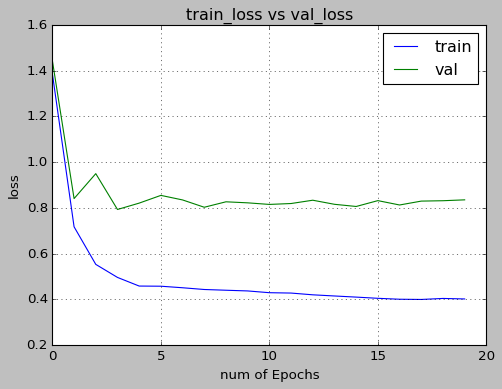

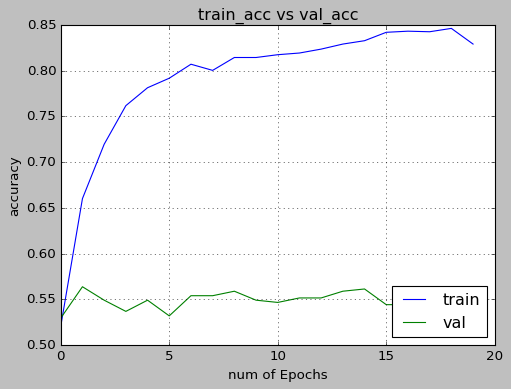

In [78]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

**PREDICTIONS**

In [80]:
predictions = model.predict_generator(val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


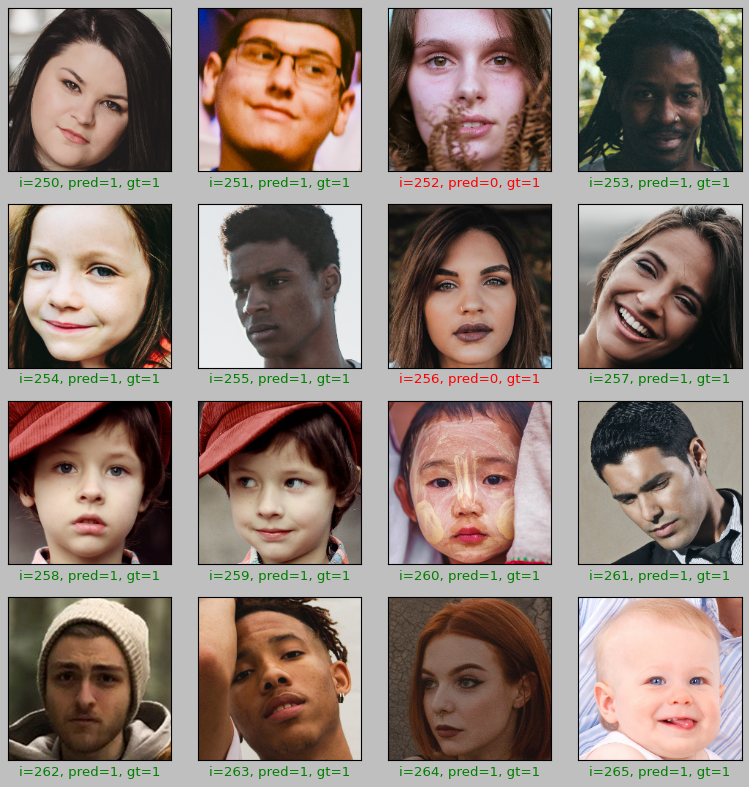

In [83]:
val_path = "./real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face/"

plt.figure(figsize=(10,10))

start_index = 250

for i in range(16):
  plt.subplot(4,4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  preds = np.argmax(predictions[[start_index+i]])
    
  gt = val.filenames[start_index+i][9:13]

  
  if gt == "fake":
    gt = 0
  else:
    gt = 1
    
  if preds != gt:
    col ="r"
  else:
    col = "g"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(load_img(val_path+val.filenames[start_index+i]))
  plt.tight_layout()

plt.show()